<a href="https://colab.research.google.com/github/hallam-flda/gambling_market_analyses/blob/main/Roulette_%26_Customer_Budgets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Budget Constraints and Casino Profitability**

## **Introduction**
During my time working in industry, it had been consistently observed that actual margin performance almost always exceeds theoretical margin performance.

More recently we discussed the possibility that this could be caused by budget constraints by both parties. I.e. The reason the Martingale strategy does not work for most gamblers is they do not have infinite budgets, nor would the casino lay a near-infinite bet.

I want to investigate the relationship between margin application and profitability when introducing these constraints.

## **Theoretical RTP**

For this exercise I will be using the example of a European Roulette table, with the only bet-type allowed being a single-number selection.

On a European Roulette wheel there are 37 numbers from 0-36 with a correct selection paying out at odds of 35/1 meaning the expected value for any spin on the roulette table is given by the formula:

$$-1 \times \left(\frac{36}{37}\right) + 35 \times \left(\frac{1}{37}\right) = -2.70\%$$

Therefore the expected profit for the casino is +2.70%, **however**, while the expected value gives us the expected returns of any individual spin, we can only expect to see this achieved for any individual gambler over a sufficiently large sample size.

In reality, individual gamblers will play for as long as their budget allows or until they feel they have reached a level of gameplay they are satisfied with. The likelihood is the session will be longer for those who experience wins and they have more opportunity to converge to the true expected value versus those who continually lose and are not able to converge.

This disproportionate drop-off in the losing player base creates an above-theoretical RTP for the Casino.


## **Constructing a Roulette Function**

In Python we can create a roulette spin function.


In [36]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random

In [54]:
def coin_flip_simulation(stake=1):
    """
    Simulates a coin flip game and calculates the total winnings/losses.

    Parameters:
    - stake (float): The cost to play each round.

    Returns:
    - winnings: The amount that is returned to the player once playing the game.
    """
    # where player selection and outcome are both randomly selected numbers beteen 0-36
    player_selection = random.randint(0,36)
    outcome = random.randint(0,36)

    if outcome == player_selection:
        winnings = 35 * stake
    else:
        winnings = 0 - stake

    return winnings

In [55]:
# test the function
total_winnings = 0
for _ in range(10000):
  total_winnings += coin_flip_simulation(1)


print(total_winnings)
print(f'for 10,000 spins the RTP is {total_winnings/100000}')

-244
for 10,000 spins the RTP is -0.00244


In isolation for one customer with 100,000 spins, the RTP looks to be reasonable, however, the casino will have lots of customers and so we should extend the simulation.

In [123]:
customer_balances = []
all_customer_balance_history = []

players = 1000
spins = 10000
for _ in range(players):
  total_winnings = 0
  customer_balance_history = []
  for _ in range(spins):
    total_winnings += coin_flip_simulation(1)
    # add the current balance to this customer's balance history
    all_customer_balance_history.append(total_winnings)
  customer_balances.append(total_winnings)

# Casino perspective for plotting
casino_customer_balances = [-x for x in customer_balances]


In [124]:
data_array1 = np.array(customer_balances)
data_array2 = np.array(all_customer_balance_history)
data_array3 = np.array(casino_customer_balances)

np.save('all_customer_balances.npy', data_array1)
np.save('all_customer_balance_history.npy', data_array2)
np.save('all_casino_customer_balances.npy', data_array3)


In [125]:
# Customer balances
cb1 = np.load('all_customer_balances.npy')
# History customer balances
cb1_history = np.load('all_customer_balance_history.npy')
# Casino balances
cb2 = np.load('all_casino_customer_balances.npy')

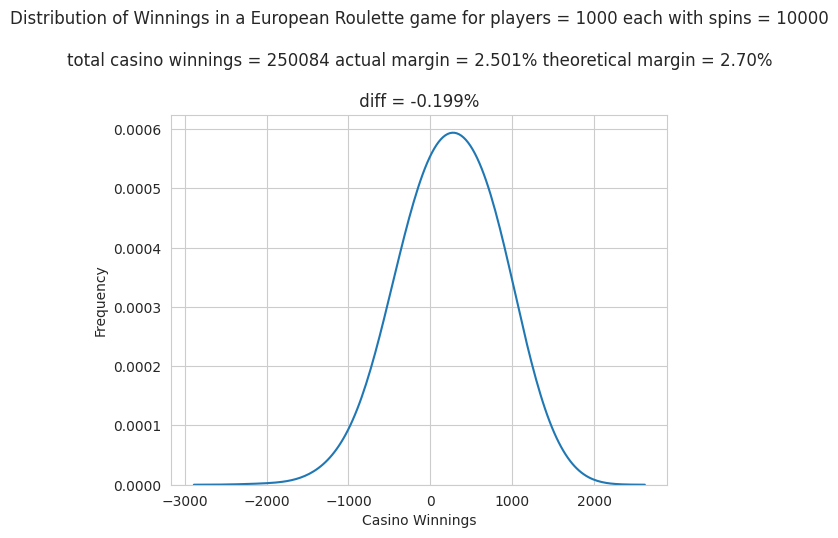

In [126]:
# plot results on density plot
sns.set_style('whitegrid')
sns.kdeplot(cb2, bw_method=0.5)
plt.xlabel('Casino Winnings')
plt.ylabel('Frequency')
plt.title(f'''Distribution of Winnings in a European Roulette game for players = {players} each with spins = {spins}
          \ntotal casino winnings = {sum(cb2)} actual margin = {(sum(cb2)/(players*spins)):.3%} theoretical margin = 2.70%
          \n diff = {((sum(cb2)/(players*spins))-.0270):.3%} ''')

plt.show()

### **Variance Within the Sample**
We have constructed a basic roulette function with 1,000 players playing 10,000 spins each. Here we have assumed that both the casino and the player have unlimited tolerance for variance. In reality it is likely that the players responsible for populating the far right of the distribution that they would have give up long before losing £3k.

Conversely we can reasonably assume in the example of a £1 roulette table, the casino would continue to lay any bet because the liability is tolerable.

Consider the below plot demonstrating the variability of customer journeys for n=10 customers.

In [94]:
x1 = np.load('customer_balances.npy')
x2 = np.load('customer_balance_history.npy')

In [95]:
print(x1)

[ -100   692 -1108  -424  -136  -244   152  -460  -496   260]


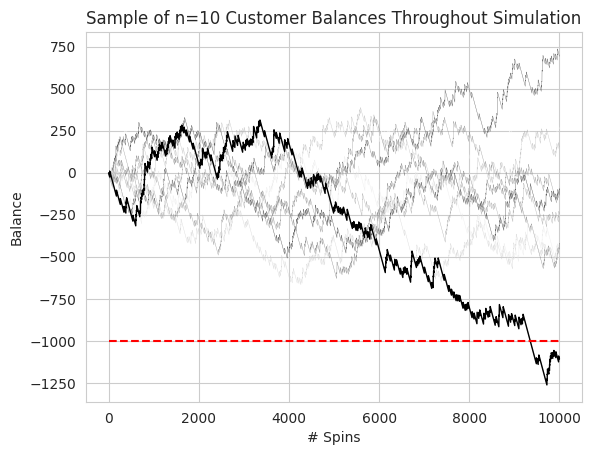

In [111]:

# Define grayscale colors
grayscale_colors = [str(i / 10) for i in range(1, 11)]  # Generate 10 grayscale values

# Plot each list as a line
for i, (sublist, color) in enumerate(zip(x2, grayscale_colors)):
    plt.plot(sublist, color=color, alpha=0.7, linewidth=0.3)  # Set transparency with alpha
plt.plot(x2[2], color='black', alpha = 1, linewidth = 1)

# Add labels, legend, and title
plt.hlines(y=-1000, xmin=0, xmax=len(x2[0]), color='red', linestyle='--')
plt.xlabel('# Spins')
plt.ylabel('Balance')
plt.title('Sample of n=10 Customer Balances Throughout Simulation')
plt.show()


How realistic is it that the highlighted customer above would continue to gamble after a sustained losings streak from +£250 to less than -£1,000?

### **Budget Constraints**


---




#### **1. Hard Budget Constraint**

I have chosen -£1,000 as an arbitray starting point. Each customer will have their own appetite for risk and own budget constraints, therefore to unlock the power of this analysis, we should look to model these constraints further down the line.

First, let's analyse how many customers hit the threshold of -£1,000 out of our sample of 1,000 customers

In [131]:
# Saving to an array flattened the shape so reshape back to 1000 customers
reshaped_data = cb1_history.reshape(1000,10000)
sub_neg_1000_customers = sum(1 for i in reshaped_data if np.any(i < -1000))
print(sub_neg_1000_customers)


165


165/1000 Customers hitting this threshold is not immaterial, what would happen if we terminated their sessions at this point? Remember the *theoretical margin* is still 2.7% but the simulated or *actual* margin will be greater if we terminate these sessions early.


In [139]:
reshaped_data = np.where(reshaped_data < -1000, np.nan, reshaped_data)

last_balances = np.nanmax(reshaped_data, axis=1)

In [141]:
print(f'original casino profit = {sum(cb2)}')
print(f'original spins = {10000*1000}')
print(f'original profit % = {sum(cb2)/(10000*1000):.3%}')
print(f'new casino profit = {sum(last_balances)}')
print(f'new # spins = {(~np.isnan(reshaped_data)).sum()}')
print(f'new profit % = {sum(last_balances)/((~np.isnan(reshaped_data)).sum()):.3%}')

original casino profit = 250084
original spins = 10000000
original profit % = 2.501%
new casino profit = 352778.0
new # spins = 9746419
new profit % = 3.620%


The original difference between theoretical and actual margin was -0.199%, whereas now with our hard budget constraint of quitting at -£1,000, the difference now stands at +0.9%


#### **2. Successive Losses**

Another time a customer may choose to stop transacting is when they have what they consider to be an 'unlucky spell'. On the European Roulette wheel you would expect any given number to appear 1 in every 37 spins, or 2.7% of the time. In this instance what would we consider to be an unlucky streak? 50, 60, 100 without your number coming in?

In [148]:
success_odds = 1/37
fail_odds = 1-success_odds
cum_odds = fail_odds
cum_odds_list = []

for _ in range(3*37):
  if _ == 0:
    cum_odds = fail_odds
  else:
    cum_odds = cum_odds*fail_odds

  cum_odds_list.append(cum_odds)

print(cum_odds_list)


[0.972972972972973, 0.9466764061358657, 0.9210905573213829, 0.8961962179343186, 0.8719746985306884, 0.8484078147866159, 0.8254778738464371, 0.8031676610397767, 0.7814604269576205, 0.7603398748776848, 0.7397901485296393, 0.7197958201910004, 0.7003418791047572, 0.6814137202100341, 0.6629971331773306, 0.6450782917401054, 0.6276437433146972, 0.6106803989007865, 0.5941755232548194, 0.5781167253290135, 0.5624919489687699, 0.5472894638615058, 0.5324978567301137, 0.5181060227644351, 0.5041031572843152, 0.4904787476279824, 0.47722256525965856, 0.4643246580904786, 0.4517753430069522, 0.43956519860135895, 0.42768505809861956, 0.41612600247433257, 0.40487935375881007, 0.3939366685220855, 0.3832897315350021, 0.3729305496016237, 0.3628513455583366, 0.3530445524351383, 0.3435028077747292, 0.3342189481051419, 0.3251860035617597, 0.31639719265468513, 0.3078459171775315, 0.2995257572538145, 0.29143046651722493, 0.2835539674221648, 0.27589034668102524, 0.26843385082478133, 0.261178881883571, 0.2541199931

I don't know a good statistical answer to this but after 3x37=111 spins, you would anticipate your number should have come up 3 times and so I will set another buffer after 111 consecutive losses.

**Note:** For any given streak of 111 consecutive spins, the odds of your number not coming up are 4.8% which feels fairly high, therefore I would still expect a reasonable number of the simulations to not experience a win.

In [150]:
balances = cb1_history.reshape(1000,10000).astype(float)

# Step 1: Calculate differences between consecutive spins
# this produces arrays of -1 for losses and +35 for wins
# shape is (1000,9999) as expected, 9999 differences for each one of the 1000 customers
diffs = np.diff(balances, axis=1)

# Step 2: Identify streaks of consecutive decreases
# decrease_streaks creates a boolean matrix of Trues and Falses
decrease_streaks = diffs < 0  # True for decreases
# at this point consecutive decreases is being initialised
# it is just 0s in the same dimensions as decrease_streaks
consecutive_decreases = np.zeros_like(decrease_streaks, dtype=int)

# Count consecutive decreases
# this is a bit like a case statement. For every element of the streak matrix
# add one to the previous streak if True or set as 0 if false
for i in range(1, decrease_streaks.shape[1]):
    consecutive_decreases[:, i] = np.where(decrease_streaks[:, i], consecutive_decreases[:, i-1] + 1, 0)

# Step 3: Replace values in the original array when the streak is >= 111
# creates boolean of true or false in line with the streak matrix
mask = consecutive_decreases >= 111  # Mask for where streaks are >= 111
balances[:, 1:][mask] = np.nan  # Apply mask, offset by one due to np.diff

# Step 4: Get the last valid balance for each customer
last_balances_2 = np.nanmax(balances, axis=1)

print(last_balances_2)  # Array of 1000 last balances


[ 2.360e+02  9.100e+01  1.310e+02  2.400e+02  6.630e+02  9.050e+02
  4.830e+02  2.500e+02  4.750e+02  7.380e+02  8.800e+01  2.340e+02
  5.910e+02  7.460e+02  6.900e+01  1.480e+02 -1.000e+00  8.200e+01
  1.350e+02  9.100e+01 -1.000e+00  3.120e+02 -1.000e+00  5.740e+02
  1.320e+02  1.400e+01  5.450e+02  1.550e+02  1.410e+02  1.300e+02
  7.080e+02  4.480e+02  1.300e+02  4.740e+02  3.110e+02  6.800e+01
  3.920e+02  2.880e+02  4.050e+02  3.520e+02  1.950e+02  1.410e+02
  6.630e+02  2.460e+02  1.310e+02  6.100e+02  1.290e+02  3.950e+02
  8.800e+01  1.980e+02  1.140e+02  5.800e+01  2.040e+02  3.130e+02
  4.090e+02  8.640e+02  2.510e+02  3.950e+02  5.430e+02  3.040e+02
 -1.000e+00  6.750e+02  3.690e+02  2.020e+02  1.220e+02  4.820e+02
  4.220e+02  5.800e+01  9.800e+02  2.900e+01  5.600e+01  4.770e+02
  1.035e+03  3.580e+02  6.300e+01  5.100e+01  4.360e+02  7.640e+02
  5.460e+02  1.320e+02  1.050e+02  2.410e+02  1.700e+01  4.660e+02
  1.520e+02  1.610e+02  1.318e+03  1.163e+03  3.040e+02  7.990

In [160]:
consecutive_decreases

array([[ 0,  1,  2, ...,  1,  2,  3],
       [ 0,  1,  2, ...,  5,  6,  7],
       [ 0,  1,  2, ...,  5,  6,  7],
       ...,
       [ 0,  0,  1, ..., 11, 12, 13],
       [ 0,  1,  2, ..., 89, 90, 91],
       [ 0,  1,  2, ..., 29,  0,  1]])

In [155]:
print(f'original casino profit = {sum(cb2)}')
print(f'original spins = {10000*1000}')
print(f'original profit % = {sum(cb2)/(10000*1000):.3%}')
print(f'new casino profit = {sum(last_balances_2)}')
print(f'new # spins = {(~np.isnan(balances)).sum()}')
print(f'new profit % = {sum(last_balances_2)/((~np.isnan(balances)).sum()):.3%}')
print(f'therefore the overall difference due to successive loss streaks is = +{sum(last_balances_2)/((~np.isnan(balances)).sum())-0.0270:.2%}' )

original casino profit = 250084
original spins = 10000000
original profit % = 2.501%
new casino profit = 352778.0
new # spins = 9535217
new profit % = 3.700%
therefore the overall difference due to successive loss streaks is = +1.00%


#### **3. Combination**

While the two proposed budget constraints will likely have a large degree of crossover, I think it is reasonable that most customers would be sensitive to losing in excess of £1000 or over 110 times in a row. Therefore I will combine the two criteria.

In [165]:

# Step 1: Replace values < -1000 with NaN
balances = np.where(balances < -500, np.nan, balances)

# Step 2: Calculate differences for consecutive losses
diffs = np.diff(balances, axis=1)

# Step 3: Identify streaks of consecutive decreases
decrease_streaks = diffs < 0  # True for decreases
consecutive_decreases = np.zeros_like(decrease_streaks, dtype=int)

# Count consecutive decreases
for i in range(1, decrease_streaks.shape[1]):
    consecutive_decreases[:, i] = np.where(decrease_streaks[:, i], consecutive_decreases[:, i-1] + 1, 0)

# Step 4: Create a combined mask for both conditions
condition1 = balances[:, 1:]  # Exclude the first column for matching size
condition2 = consecutive_decreases >= 111
combined_mask = np.isnan(condition1) | condition2

# Step 5: Replace values based on the combined mask
balances[:, 1:][combined_mask] = np.nan

# Step 6: Get the last valid balance for each customer
last_balances_3 = np.nanmax(balances, axis=1)


In [166]:
print(f'original casino profit = {sum(cb2)}')
print(f'original spins = {10000*1000}')
print(f'original profit % = {sum(cb2)/(10000*1000):.3%}')
print(f'new casino profit = {sum(last_balances_3)}')
print(f'new # spins = {(~np.isnan(balances)).sum()}')
print(f'new profit % = {sum(last_balances_3)/((~np.isnan(balances)).sum()):.3%}')
print(f'therefore the overall difference due to successive loss streaks & overall loss is = +{sum(last_balances_3)/((~np.isnan(balances)).sum())-0.0270:.2%}' )

original casino profit = 250084
original spins = 10000000
original profit % = 2.501%
new casino profit = 352778.0
new # spins = 7939338
new profit % = 4.443%
therefore the overall difference due to successive loss streaks & overall loss is = +1.74%


#### **4. Further Budget Constraints**

In reality each customer will have their own unqiue set of circumstances that dictates whether they will place the next bet or not. This will relate to income, propensity to gamble, understanding of statistics and many more factors.

The purpose of this exercise was to prove the existence of a difference between theoretical and achieved margins when introducing a fairly reasonable constraint from the gambler's side.